
# SolverLab documentation for Salome

## Introduction

**SOLVERLAB** is divided into two Python packages:

- `cdmath` gathers elementary tools to build and solve matrix systems
- `CoreFlows` gathers tools for efficiently solving classical engineering problems

**SOLVERLAB** brings together the `MEDCOUPLING` and `PETSc` libraries to create a powerful, practical and easy-to-use tool for solving partial differential equations.

The project is initially hosted on [GitHub](https://github.com/ndjinga/SOLVERLAB) and a stable version is incorporated into **Salome**.

## Installation

**SOLVERLAB** is installed with **Salome**. A set of resources is available in the installation: `path-to-salome/INSTALL/SOLVERLAB/share`, in particular the documentation for the `CoreFlows` module in pdf in `SOLVERLAB/share/doc` or in `doxygen` form gathering all the options available for each model can be found in `SOLVERLAB/share/doc/coreflows-dev-doc/html/index.html`.

## Getting started

Once **Salome** and **SOLVERLAB** have been installed, simply load the **SOLVERLAB** environment from the file present in the installation:

```bash
source path-to-salome/INSTALL/SOLVERLAB/env_SOLVERLAB.sh
```

## Example: 1D diffusion equation

This example is taken from the heat equation example on [GitHub](https://github.com/ndjinga/SOLVERLAB/blob/master/CDMATH/tests/doc/1DHeatEquation/HeatEquation1D_RegularGrid.ipynb)

### Development in finite volumes

In this example, we consider the following diffusion equation:

$$
\frac{partial u}{partial t} = d \frac{partial^2 u}{partial x^2}
$$

on the 1D domain, $\Omega = [0,1]$ and where $d$ is the diffusion coefficient. Consider periodic boundary conditions on both sides and an initial condition of the form $u(x,t=0) = u_0(x)$.

This equation is to be solved numerically using the finite volume method. To do this  
we start by decomposing the domain into N intervals $[x_i, x_{i+1}]_{i=1..N}$ of size $\Delta x = 1 / N$.  
Similarly, the time domain is discretized and the time interval is denoted $\Delta t_n = t_{n+1} - t_n$.  
So we're looking for mean values:

$$
u_i^n = \frac{1}{\Delta x} \int_{x_i}^{x_{i+1}} u(x,t_n) \mathrm{d}x
$$

on each space interval.

Development in finite volumes finally gives the equation:

$$
\frac{u_i^{n+1} - u_i^n}{\Delta t_n} = d \frac{u_i+1}^{n,n+1} - 2u_i^{n,n+1} + 2 u_{i-1}^{n,n+1}}{\Delta x^2}
$$

with $u_i^{n,n+1} = \frac{1}{\Delta t} \int_{t_n}^{t_{n+1}} u_i(t) \mathrm{d}t$. This quantity can be expressed simply using the rectangle formula  
in two ways:

- $u_i^{n,n+1} = \frac{1}{\Delta t_n} \int_{t_n}^{t_{n+1}} u_i(t) \mathrm{d}t = u_i^n$ leading to an explicit solution with a stability criterion $\Delta t_n \lt \Delta x^2 / 2d$.
- $u_i^{n,n+1} = \frac{1}{\Delta t_n} \int_{t_n}^{t_{n+1}} u_i(t) \mathrm{d}t = u_i^{n+1}$ leading to an implicit solution requiring the inversion of an (unconditionally stable) matrix.

For the explicit solution, we obtain :

$$
u_i^{n+1} = u_i^{n} + \frac{d \Delta t_n}{\Delta x^2} \left( u_{i+1}^n - 2 u_{i}^n + u_{i-1}^n\right)
$$

and for the implicit resolution, we obtain :

$$
\left(1 + 2 \frac{d \Delta t_n}{\Delta x^2} \right) u_i^{n+1} - \frac{d \Delta t_n}{\Delta x^2} \left[ u_{i+1}^{n+1} + u_{i-1}^{n+1}\right] = u_i^n
$$

### Numerical solution

In this example, we'll use only the `cdmath` package. First, we define the problem parameters, the initial condition `U_initial` and the cell coordinates:

In [1]:
from math import sin, pi
import matplotlib.pyplot as plt

import cdmath

# Parameters
N = 100  # number of elements
d = 0.1  # diffusion coefficient
dt = 0.00001  # time interval
time_steps = 100

dx = 1.0 / N
x = [0.5 * dx + i * dx for i in range(N)]
U_initial = [
    0.5 * (1 + sin(4 * pi * xi - pi * 0.5)) * int(xi < 0.5) * int(0 < xi)
    + int(0.6 < xi) * int(xi < 0.85)
    for xi in x
]


For the explicit solution, the matrix is written as $\mathbf{U}^{n+1} = \mathbf{M} \mathbf{U}^n$ :

In [2]:
# Explicit resolution
print(f"CFL condition: {dt:2.3e} < {dx * dx / 2 / d:2.3e}")
mat_explicit = cdmath.SparseMatrixPetsc(N, N, 3)
for i in range(N):
    mat_explicit.setValue(i, (i + 1) % N, d * dt / dx**2)
    mat_explicit.setValue(i, i, 1 - (2 * d * dt / dx**2))
    mat_explicit.setValue(i, (i + 1) % N, d * dt / dx**2)

CFL condition: 1.000e-05 < 5.000e-04



If necessary, check that the stability condition is satisfied. Then simply loop through the time steps

In [3]:
U_explicit = cdmath.Vector(N)
for i in range(N):
    U_explicit[i] = U_initial[i]

for nn in range(time_steps):
    U_explicit = mat_explicit * U_explicit


For implicit solving, we write the matrix such that $\mathbf{A} \mathbf{U}^{n+1} = \mathbf{U}^n$.  
The probem then requires the matrix $\mathbf{A}$ to be inverted at each time step. The `cdmath` linear system solver is used for this. The solving method is based on Krylov subspaces.

In [4]:
# Implicit resolution
mat_implicit = cdmath.SparseMatrixPetsc(N, N, 3)

for i in range(N):
    mat_implicit.setValue(i, (i + 1) % N, -d * dt / dx**2)
    mat_implicit.setValue(i, i, 1.0 + (2 * d * dt / dx**2))
    mat_implicit.setValue(i, (i + 1) % N, -d * dt / dx**2)

U_implicit = cdmath.Vector(N)
for i in range(N):
    U_implicit[i] = U_initial[i]

LS = cdmath.LinearSolver(
    mat_implicit, U_implicit, 50, 1e-5, "GMRES", "ILU"
)  # 50: max number of iterations, 1e-5: precision
LS.setComputeConditionNumber()

for nn in range(time_steps):
    LS.setSndMember(U_implicit)
    U_implicit = LS.solve()
    if not LS.getStatus():
        raise RuntimeError("Implicit resolution did not converge")

 Maximal singular value = 1, Minimal singular value = 1, Condition number = 1
 Maximal singular value = 1, Minimal singular value = 1, Condition number = 1
 Maximal singular value = 1, Minimal singular value = 1, Condition number = 1
 Maximal singular value = 1, Minimal singular value = 1, Condition number = 1
 Maximal singular value = 1, Minimal singular value = 1, Condition number = 1
 Maximal singular value = 1, Minimal singular value = 1, Condition number = 1
 Maximal singular value = 1, Minimal singular value = 1, Condition number = 1
 Maximal singular value = 1, Minimal singular value = 1, Condition number = 1
 Maximal singular value = 1, Minimal singular value = 1, Condition number = 1
 Maximal singular value = 1, Minimal singular value = 1, Condition number = 1
 Maximal singular value = 1, Minimal singular value = 1, Condition number = 1
 Maximal singular value = 1, Minimal singular value = 1, Condition number = 1
 Maximal singular value = 1, Minimal singular value = 1, Conditi


Finally, you can plot the profiles with `matplotlib` :

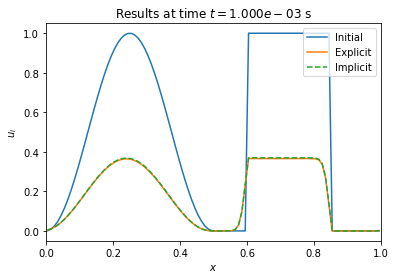

In [5]:
# Post processing
fig, ax = plt.subplots()
ax.plot(x, U_initial, label="Initial")
ax.plot(x, U_explicit.getArray(), label="Explicit")
ax.plot(x, U_implicit.getArray(), linestyle="--", label="Implicit")

ax.legend(loc="upper right")
ax.set_title(f"Results at time $t={time_steps*dt:2.3e}$ s")
ax.set_xlabel("$x$")
ax.set_ylabel("$u_i$")
ax.set_xlim(0, 1)

fig.savefig("diffusion_1D.svg")



![AD diffusion results](diffusion_1D.svg)

* * *

## Example: stationary diffusion in 2D

This example seeks to solve the diffusion equation in a 2D context:

$$
\lambdaDelta T=\Phi(T) + \lambda_{sf} (T_{fluid}-T)
$$

with

- T$ the unknown, defined for the solid
- the conductivity of the solid
- $\Phi(T)$ the source term
- $T_{fluid}$ the temperature of a fluid and $\lambda_{sf}$ calibrating the temperature exchanges between the fluid and the solid.

The `CoreFlows` package allows you to parameterize the resolution of this equation very simply. To do this, first define the resolution domain by constructing a mesh using the `cdmath` construction tool:

In [6]:
import CoreFlows as cf
import cdmath
from math import sin, pi

xinf, xsup = -0.5, 0.5
yinf, ysup = -0.5, 0.5
nx, ny = 5, 5
mesh = cdmath.Mesh(xinf, xsup, nx, yinf, ysup, ny, 0)  # Regular triangular mesh


This mesh is a rectangle (cuboid in 3D) made up of cells with 3 nodes (4 in 3D). Note that it is also possible to import meshes in `MED` format, for example.

With this mesh, we can create the *problem* that will be used to solve the diffusion equation:

In [7]:
problem = cf.StationaryDiffusionEquation(2, True, 1.75)
problem.setMesh(mesh)


 Simulation on 1 processors
Processor [0] ready for action

 Stationary diffusion problem with conductivity 1.75 and finite elements method

Mesh has 50 cells and 36 nodes

2D Finite element method on triangles



The creation of this problem takes three arguments:

- the dimmension of the space, in this case `2`.
- a Boolean indicating whether the solution is to be solved using the finite element method (`True`) or the finite volume method (`False`)
- the material conductivity value, here `1.75`.

As far as boundary conditions are concerned, we must first gather the nodes at the edges of the domain into named entities. In this case, we seek to retrieve the nodes on a plane by giving the coordinate value (e.g. `xsup`), the direction number (`0` for $x$), a precision value and finally, the name of the entity :

In [8]:
eps = 1e-6
mesh.setGroupAtPlan(xsup, 0, eps, "Right")
mesh.setGroupAtPlan(xinf, 0, eps, "Left")
mesh.setGroupAtPlan(ysup, 1, eps, "Front")
mesh.setGroupAtPlan(yinf, 1, eps, "Back")

Boundary conditions can then be assigned:

In [9]:
problem.setDirichletBoundaryCondition("Right", 0)
problem.setDirichletBoundaryCondition("Left", 0)
problem.setDirichletBoundaryCondition("Front", 0)
problem.setDirichletBoundaryCondition("Back", 0)

Here we're talking about Dirichlet boundary conditions, but it's also possible to apply other types of boundary conditions (Neumann, ...). In this case, please refer to the documentation.  

The source term is a field commonly applied to the second member of the equation (*RHS* or *right hand side*). Here, we'd like to apply a source term whose intensity depends on its position in the domain. To do this, we start by creating a field, giving it a name, a type (nodes, cells), a reference mesh and its number of components:

In [10]:
source = cdmath.Field("RHS_field", cdmath.NODES, mesh, 1)

Field values can be assigned by traversing the list of nodes in its mesh:

In [11]:
for i in range(mesh.getNumberOfNodes()):
    Ni = mesh.getNode(i)
    x = Ni.x()
    y = Ni.y()

    source[i] = 2 * pi * pi * sin(pi * (x - xinf)) * sin(pi * (y - yinf))

Finally, all that remains is to give this field to the problem:

In [12]:
problem.setHeatPowerField(source)

For the fluid, its temperature can be defined by giving a uniform value or a field:

In [13]:
problem.setFluidTemperature(0.5)

Before moving on to solving the problem, we can give it a name. This name is used to save the result files.

In [14]:
fileName = "StationaryDiffusion_2DEF_StructuredTriangles"
problem.setFileName(fileName)

In this case, the problem is solved in a single step. We can specify the solving algorithm and the preconditioner to be given to `PETSc`.

In [15]:
problem.setLinearSolver(cf.GMRES, cf.ILU)

We can now move on to the resolution:

In [16]:
problem.initialize()
exitStatus = problem.solveStationaryProblem()
if not exitStatus:
    raise RuntimeError(f"{fileName} simulation failed")


 Initialisation of the computation of the temperature diffusion in a solid using Finite elements method

Number of unknown nodes 16, Number of boundary nodes 20, Number of Dirichlet boundary nodes 20

!!! Running test case StationaryDiffusion_2DEF_StructuredTriangles using Finite elements method

## Système linéaire résolu en 4 itérations par le solveur gmres et le preconditioneur ilu, précision demandée = 1.00e-06
Saving numerical results



The result fields (here the unknown `T` called `Temprature` in this problem) are automatically saved and can be viewed with **Salome**. It is also possible to retrieve the solution field in python to extract interesting properties such as the maximum value:

In [17]:
T_field = problem.getOutputTemperatureField()
print(T_field.max())

0.5342071419837199


Finally, the problem can free up the memory used to store the various `PETSc` objects:

In [18]:
problem.terminate()